<a href="https://colab.research.google.com/github/Craig-UK/artificial-intelligence/blob/main/StockPreBasedOffModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [168]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [169]:
import pandas as pd
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as web

start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

data = web.get_data_yahoo("ATVI", start, end)

data.to_csv("stock_data.csv")

[*********************100%***********************]  1 of 1 completed


In [170]:
data = pd.read_csv("stock_data.csv")

In [171]:
data = data[["Date", "Close"]]

In [172]:
data

,Date,Close
0,2020-01-02,58.650002
1,2020-01-03,58.669998
2,2020-01-06,59.740002
3,2020-01-07,60.340000
4,2020-01-08,59.880001
...,...,...
812,2023-03-24,84.389999
813,2023-03-27,84.330002
814,2023-03-28,84.349998
815,2023-03-29,84.540001


In [173]:
data.columns = ["ds", "y"]

In [174]:
data

,ds,y
0,2020-01-02,58.650002
1,2020-01-03,58.669998
2,2020-01-06,59.740002
3,2020-01-07,60.340000
4,2020-01-08,59.880001
...,...,...
812,2023-03-24,84.389999
813,2023-03-27,84.330002
814,2023-03-28,84.349998
815,2023-03-29,84.540001


In [175]:
from prophet import Prophet

In [176]:
prophet = Prophet(daily_seasonality=True)
prophet.fit(data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjgsgay_/lrretk76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjgsgay_/opn5j618.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38503', 'data', 'file=/tmp/tmpqjgsgay_/lrretk76.json', 'init=/tmp/tmpqjgsgay_/opn5j618.json', 'output', 'file=/tmp/tmpqjgsgay_/prophet_model3w0ef0xa/prophet_model-20230330163144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:31:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:31:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [177]:
future_dates = prophet.make_future_dataframe(periods=30)
predictions = prophet.predict(future_dates)

In [178]:
from prophet.plot import plot_plotly

plot_plotly(prophet, predictions)

In [179]:
pred_month = predictions["yhat"][-30:]

In [180]:
old_arr = []
full_arr = []
for x in pred_month:
  old_arr.append(x)
old_arr
for x in predictions["yhat"][-60:]:
  full_arr.append(x)
full_arr

[81.61281687948475,
 81.70036682287453,
 81.53897019926684,
 81.33264504448242,
 81.25358425211067,
 81.19285294314338,
 80.68298963340169,
 80.46163102687987,
 80.12948794056642,
 79.93571510588917,
 79.77353713676547,
 79.05848784255961,
 78.80728908647907,
 78.46666887918592,
 78.28654969434307,
 78.16055604800715,
 77.6872897434486,
 77.558391624296,
 77.35855469681778,
 77.33569819588877,
 77.38109334347061,
 77.47882336593828,
 77.54878198585398,
 77.54650575854203,
 77.71650569401811,
 77.94669187064478,
 78.51894709485848,
 78.71116145404233,
 78.80933269401301,
 79.0562549543419,
 79.33857557003606,
 79.57722838939205,
 79.7652818023931,
 79.9132530687866,
 80.05574370135587,
 80.08059040598772,
 80.23231123945169,
 80.39971741747651,
 80.50630230639004,
 80.54803626936591,
 80.53862011064889,
 80.51605321358274,
 80.37171236910821,
 80.35372257009983,
 80.35449189966896,
 80.30102378284643,
 80.19263700799488,
 80.04614795421325,
 79.90237273057353,
 79.65514671247871,
 79.55

In [181]:
import numpy as np, numpy.random
value = np.random.dirichlet((9.5, 0.5), 30).transpose()

values = np.sort(value[0])
same_one = []

for i,x in enumerate(pred_month):
  if i == 0:
    same_one.append(x)
  else:
    same_one.append(x + values[i])
same_one
original_values = full_arr.copy()
full_arr[-30:] = same_one
print(value[0])
print(values)

[0.98652209 0.89277734 0.9989199  0.87172481 0.94263986 0.78938372
 0.99240037 0.94458948 0.99997531 0.98952889 0.97094857 0.86261315
 0.93022457 0.97717858 0.98426508 0.95078455 0.99876013 0.99946709
 0.99976435 0.97073982 0.96192031 0.99782228 0.96033555 0.8713599
 0.91983578 0.99998788 0.94069244 0.95845807 0.98177833 0.86147699]
[0.78938372 0.86147699 0.86261315 0.8713599  0.87172481 0.89277734
 0.91983578 0.93022457 0.94069244 0.94263986 0.94458948 0.95078455
 0.95845807 0.96033555 0.96192031 0.97073982 0.97094857 0.97717858
 0.98177833 0.98426508 0.98652209 0.98952889 0.99240037 0.99782228
 0.99876013 0.9989199  0.99946709 0.99976435 0.99997531 0.99998788]


<Axes: >

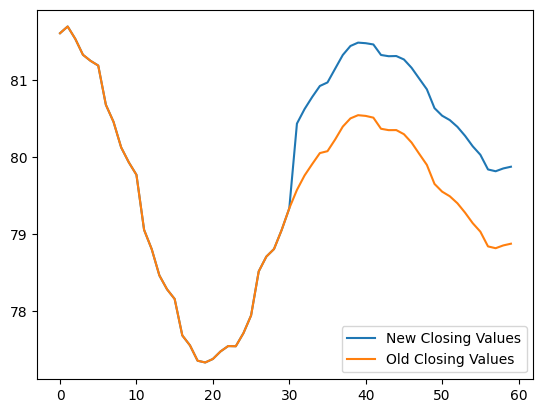

In [182]:
new_preds = pd.DataFrame(full_arr, columns = ["New Closing Values"])
old_preds = pd.DataFrame(original_values, columns = ["Old Closing Values"])
df_merged = pd.concat([new_preds, old_preds], axis=1)
df_merged
df_merged.plot()

In [242]:
from sklearn.metrics import accuracy_score
start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()
data = web.get_data_yahoo("AAPL", start, end)
data.to_csv("stock_data.csv")
data = pd.read_csv("stock_data.csv")
data = data[["Date", "Close"]]
prophet = Prophet(daily_seasonality=True)
data.columns = ["ds", "y"]
prophet.fit(data[:-100])
future_dates = prophet.make_future_dataframe(periods=100)
predictions = prophet.predict(future_dates)
plot_plotly(prophet, predictions)
real = data["y"][-100:]
predict = predictions["yhat"][-100:]
if sum(real) > sum(predict):
  total = ((sum(real) - sum(predict)) / sum(real)) * 100
  #print(total)
else:
  total = ((sum(predict) - sum(real)) / sum(predict)) * 100
  #print(total)
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
print(smape(real, predict))

[*********************100%***********************]  1 of 1 completed

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjgsgay_/lgj9ldw_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqjgsgay_/740g_et7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6731', 'data', 'file=/tmp/tmpqjgsgay_/lgj9ldw_.json', 'init=/tmp/tmpqjgsgay_/740g_et7.json', 'output', 'file=/tmp/tmpqjgsgay_/prophet_modelt7wb960l/prophet_model-20230330173636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


17:36:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


6.384289113708359
